## 1a

Show that $$\frac{\delta C}{\delta q_i} = - \frac{p_i}{q_i}$$.

\begin{eqnarray}
\frac{\delta C}{\delta q_i} & =
\sum_j \frac{\delta p_j log \frac{p_j}{q_j}}{\delta q_i} =\\
\frac{\delta p_i log \frac{p_i}{q_i}}{\delta q_i} &= \frac{\delta p_i (log p_i - log q_i)}{\delta q_i} =\\
-\frac{\delta p_i log q_i}{\delta q_i} &= -p_i \frac{1}{q_i} = \frac{p_i}{q_i}
\end{eqnarray}

##1b

Show that $$\frac{\delta C}{\delta x_i} = - p_i + q_i$$ with $$q_i = \frac{e^{x_i}}{\sum_k e^{x_k}}$$

\begin{align}
\frac{\delta C}{\delta x_i} &=
    \sum_j \frac{\delta p_j log \frac{p_j}{q_j}}{\delta x_i} =\\
\sum_j \frac{\delta p_j (log p_j - log q_j)}{\delta x_i} &=
    \sum_j -\frac{\delta p_j log q_j}{\delta x_i} =\\
\sum_j -p_j \frac{1}{q_j} \frac{\delta q_j}{\delta x_i} &=
\sum_{j \ne i} - \frac{p_j}{q_j} \frac{\delta q_j}{\delta x_i} - \frac{p_i}{q_i} \frac{\delta q_i}{\delta x_i}\\
\end{align}

Substituting
\begin{equation}
\frac{\delta q_j}{\delta x_i} = \frac{\delta \frac{e^{x_j}}{\sum_k e^{x_k}}}{\delta x_i} =
e^{x_j} \frac{-1}{(\sum_k e^{x_k})^2} e^{x_i} = -q_j q_i
\end{equation}

and
\begin{equation}
\frac{\delta q_i}{\delta x_i} = \frac{\delta \frac{e^{x_i}}{\sum_k e^{x_k}}}{\delta x_i} =
\frac{e^{x_i}}{\sum_k e^{x_k}} + e^{x_i}\frac{-1}{(\sum_k e^{x_k})^2} e^{x_i} = q_i - q_i^2
\end{equation}

into the above.

\begin{align}
\frac{\delta C}{\delta x_i} &= \sum_{j \ne i} \frac{p_j}{q_j} q_j q_i - \frac{p_i}{q_i}(q_i - q_i^2) =\\
\sum_{j \ne i} p_j q_i - p_i + p_i q_i &= \sum_j p_j q_i - p_i = -p_i + q_i \big\vert with \sum_j p_j = 1\\
\end{align}

##1c

###1
The second form doesn't suffer from the singularity of $\frac{p_i}{q_i}$ and will be more stable during gradient descent.
###2
In the second form, the gradient will be zero when $p_i$ and $q_i$ are equal, whereas $\frac{p_i}{q_i}$ will never reach zero.


## Reversing t-SNE

Far distances in the feature space would be represented by much smaller distances in the embedding. Such a similarity might make sense if the points in the feature space were highly compressed in the center with a diminishing point density towards the edges.
In the embedding the points would be more evenly distributed thus providing a more useful relative scale similar to a log-scale plot.

## Exercise Sheet 2
# t-Distributed Stochastic Neighbor Embedding (50P)

In this sheet, we will be implementing a more advanced version of t-SNE from the one described in the paper by Laurens van der Maaten (available on ISIS). It is based on the author's version and is available on his homepage at http://lvdmaaten.github.io/tsne/ . The extended version has various tricks designed to improve performance. 

### Part I: Implementing t-SNE (20P)

Your task here is to complete the missing cost segments for t-SNE and confirm they are running properly by running the small test provided below. 

As a reminder, here is the simple version of t-Distributed SNE as described in the paper

* compute pairwise affinities $p_(j|i)$ with perplexity perp using $p_(j|i) = \frac{\exp(-||x_i - x_j||^2/(\sigma))}{\sum_{k \neq i} \exp(-||x_i - x_k||^2/(\sigma))}$ (using $\sigma$ instead of $2\sigma^2$ in the denominators
* Optimize the perplexity for each element i to give the target perplexity (provided in optimize_perplexity)
* Rather than using $p_{j|i}$, compute $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$
* Sample initial solution $Y^{0}$
* for t=1 to max_iter do:
   * compute $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1})}{\sum_{k \neq i}(1 + ||y_i - y_k||^2)^{-1})}$
   * compute gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1} $
   * set $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2}) $, where $Y^{t-j}$ is the value of $Y$ from period $t-j$ and $\alpha (t) = 0.5 $ if $t<250$ and $0.8$ otherwise
   
Use $Y^{t}=(0,0,...,0)$ for $t<0$   

The main method has numerous paremeters which you can use to change the behaviour during testing. 

* The perplexity, learning rate ($\eta$), early exaggeration, initial seed and the number of iterations impact performance
* Remaining parameters mostly regulate visualization. It is possible to print intermediate embeddings for analyzing training progress. 

In [1]:
import utils
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

def cost_function(P,Q):
    """
    Calculate the cost function of t-SNE for the given conditional probabilities
    
    The cost function is the KL divergence C = KL(P||Q)
    
    inputs:
    P - An NxN array, containing p_ij as described above
    Q - An NxN array, containing q_ij as described above
    
    returns:
    C - Value of the cost function
    """
    return np.sum(P * np.log(P / Q))

def student_t_distribution(Y):
    """
    Calculate the join probabilities q_ij given in equation 4 of the paper
    
    inputs:
    Y - An Nxd array containing the current low dimensional embedding
    
    returns:
    Q - NxN array containing the joint probabilities
    """
    N = Y.shape[0]
    Q = 1.0 / (1 + distance_matrix(Y, Y) ** 2)
    Q /= np.sum(Q) - N # - N for the diagonal of ones

    Q = np.maximum(Q, 1e-12) # This is important
    return Q


def compute_gradient(P,Q,Y):
    """
    Computes the gradient as described above.
    
    P - An NxN array, containing p_ij as described above
    Q - An NxN array, containing q_ij as described above
    Y - An Nx2 array containing the embedding
    """
    N,d = Y.shape
    res = np.empty([N, d])
    W = (P - Q) / (1 + distance_matrix(Y, Y) ** 2)
    for i in xrange(N):
        Yd = Y[i] - Y
        res[i] = 4 * np.dot(W[i], Yd)
    return res


You do not need to modify the tSNE method.

In [2]:
import utils
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt

def TSNE(data, max_iter = 500, labels = None, target_dimension = 2, 
         intermediate_dimension = 50, perplexity=20, 
         create_gif = False, eta = 200, early_exaggeration=1, 
         seed=31415, visualize=True,number_of_plots = 5):
    """
    Runs t-SNE and computes the resulting embedding Y.
    
    Periodically saves the embedding Y as a scatter plot ( with color = labels if available).
    
    
    inputs:
    data - NxD array with the original data
    max_iter - Number of iterations for optimizing Y
    labels - An array contaning the labels associated with each point, in case they are
            available. Used for plotting progress
    target_dimension - The dimension of the embedding tSNE should produce
    intermediate_dimension - The number of components that the original dataset should be reduced to initially.
                             Computation becomes tricky in case we have high dimensional data and don't reduce it
                             beforehand (distances can explode easily over 500+ dimensional data).
    perplexity - Target perplexity to which all conditional distributions should be tuned. 10-20 range yielded good
                 results during prototyping
    early_exaggeration - True if we wish to utilize early exaggeration. This is a method often used with tSNE, 
                        which apparentlly improves performance early on.
    create_gif - Set to true in case we wish to save all figures in a gif. Requires imagemagic to do so.
    seed - The seed we'll be using to initialize the embedding.
    visualize = True in case we wish to plot intermediate results. 
    number_of_plots - Determines how many plots of intermediate states should be shown.
    """
    
    # Part 1: Initialize everything you'll be using
    N,d = data.shape
    momentum = 0.5 # This is alpha(t)

    if(d>intermediate_dimension):
        print "Reducing intermediate dimension from ",d," to ",intermediate_dimension," using PCA "
        data = utils.pca(data,d=intermediate_dimension)
    
    # Part 2: Compute the pairwise affinities p j|i
    P, sigmas = utils.optimize_perplexity(data, target_perplexity=perplexity, tolerance = 0.001)
    
    print "Started work on t-SNE"
    
    # P might have values that are too small.
    P[np.isnan(P)] = 1e-6
    P = np.maximum(P, 1e-12);
    
    # Part 3: Compute p_(i,j)
    P = (P+P.T)/(2.0*N)
    
    # Part 4: Sample initial solution Y_0
    np.random.seed(seed)
    Y = 0.1*np.random.randn(N, target_dimension)
    
    #Apparently it can't be np.zeros((N,1)) for the mean
    Y_prev = np.zeros((N,target_dimension))
    
    # Part 5: Optimize Y over max_iter iterations
    plotind=0
    
    dY = np.zeros((N,target_dimension));
    iY = np.zeros((N,target_dimension));
    gains = np.ones((N, target_dimension));
    min_gain = 1e-2
    
    cost = []
    
    period = np.floor(max_iter/number_of_plots)
    
    if(early_exaggeration==1):
        P=P*4.
    
    for t in range(max_iter): 
        #print t
        if((t==2*period or (period>50 and t==100)) and early_exaggeration == 1):
            P = P/4.
            # We are done with the exaggeration. Usually it's stopped after more runs (100+)
            # but we're dealing with mostly simple problems
        if(t>250):
            momentum = 0.8 
        if(np.sum(np.isnan(Y))>0):
            print "ran into NaNs at iteration", t,Y
            print "Previous value (without the NaNs) was:", Y_prev
        
        
        # Compute Q

        Q = student_t_distribution(Y)
        
        # Visualize progress
        
        if(t%period==0 and visualize):
            f = plt.figure(figsize=(6,6))
            p = f.add_subplot(1,1,1)
            if(labels!=None):
                p.scatter(Y[:,0],Y[:,1],c=labels)
            else:
                p.scatter(Y[:,0],Y[:,1])
            plt.title("At iteration %d cost = %.4f"%(t,cost_function(P,Q)))
            plt.show()
            if(create_gif):
            # I created the tmp folder before starting, I think you should too
            # While debugging you might want to disable this and plot results directly
            # You can modify this with additional information you might find beneficial
                f.savefig('tmp/embedding-%02d.png'%plotind)
                plt.close(f)
            plotind+=1
        
        cost.append(cost_function(P,Q))
        
        # Compute the gradient
        dY = compute_gradient(P,Q,Y)
        
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        
        iY = momentum * iY - eta * (gains * dY);
        
        Y = Y + iY;
        
        Y = Y - np.tile(np.mean(Y, 0), (N, 1));
        if (t%period==0 and visualize):
            print "Cost function at iter ", t," = ",cost_function(P,Q)
    
    # Now let's make a movie
    if(create_gif and visualize):
        print "Converting to a .gif"
        files = " ".join(['tmp/embedding-%02d.png'%t for t in range(plotind)])
        print(files)
        # This needs imagemagic
        os.system('convert -delay 10 ' + files + ' tsne.gif')
    
    # Visualize the cost function
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(len(cost)), cost)
    plt.title("Cost function over time")
    plt.subplot(1,2,2)
    plt.scatter(Y[:,0],Y[:,1],c=labels)
    plt.title("Final embedding after %d iterations"%max_iter)
    plt.show()

Populating the interactive namespace from numpy and matplotlib
JLMN
Generating swiss roll
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


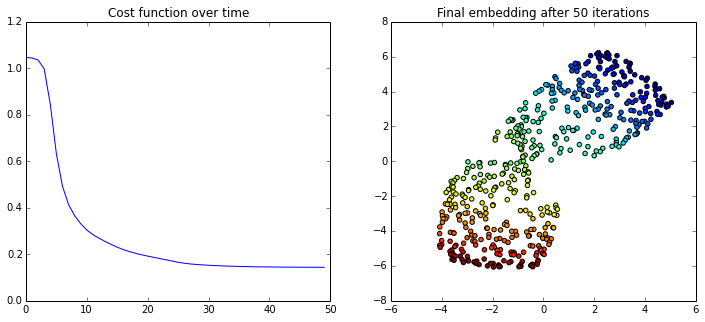

In [3]:
import utils
%pylab inline
print "JLMN"
d,c=utils.get_data(type=1)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=35, 
     early_exaggeration=0, seed=1, visualize = False, create_gif = True)

## Part 2: Experimenting With t-SNE (30P)

The utils file contains get_data(type) which provides you with 5 different datasets for experiments:

* A swiss roll, as seen in the previous sheet
* A collection of digits (less complex than MNIST)
* Boston housing dataset
* Iris dataset
* A collection of clusters (you can modify the number by providing num_blobs = x when using get_data).

Using your implementation of tSNE experiment on the various dataset and answer the following questions. Along with the answere, include results from running tSNE in the data cell beneath each question where you should execute code with certain parameters ( different values for the perplexity, number of iterations...). Only keep results relevant to answering the question. An example is provided bellow:

Populating the interactive namespace from numpy and matplotlib
JLMN
Loading boston housing
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


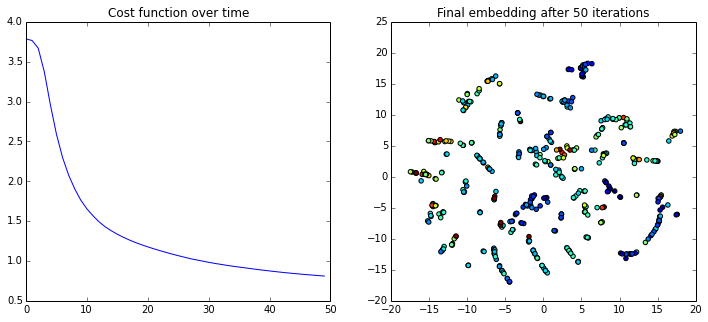

In [4]:
import utils
%pylab inline
print "JLMN"
d,c=utils.get_data(type=3)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=5,  early_exaggeration=0, seed=1, visualize = False)

How does perplexity impact performance? What kind of extreme behaviour can perplexity cause?

Answer:
It doesn't affect performance.
With a too small perplexity the data is scattered and no global structure is preserved.
With a too high perplexity clusters collapse to a single point.

Too small perplexity
Loading boston housing
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


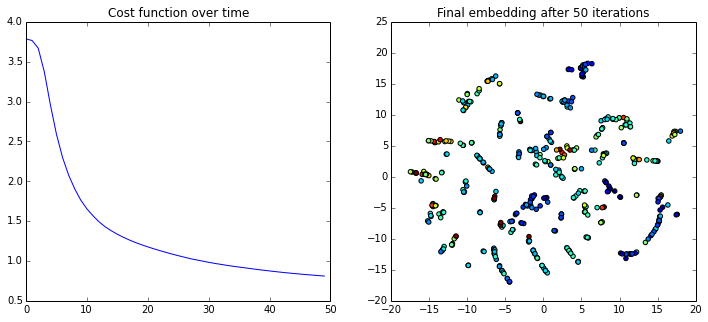

Too big perplexity
Generating clusters
Reducing intermediate dimension from  70  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


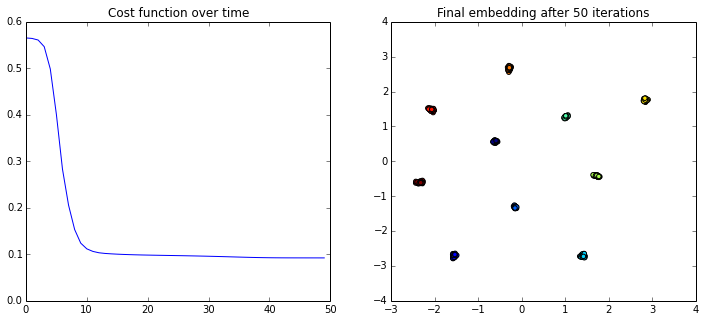

In [5]:
print('Too small perplexity')
d,c=utils.get_data(type=3)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=5,  early_exaggeration=0, seed=1, visualize = False)
print('Too big perplexity')
d,c=utils.get_data(type=5)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=50,  early_exaggeration=0, seed=1, visualize = False)

Is the optimization problem convex? How does altering the initial seed impact performance? How would you deal with this when using tSNE on a more complex dataset (here: digits)?

Answer:
No, the optimization can get stuck in local minima.
Possible solutions would be to take the best out of multiple randomly seeded runs and using simulated annealing for the update step width of the gradient descent.

Loading digits
Reducing intermediate dimension from  64  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


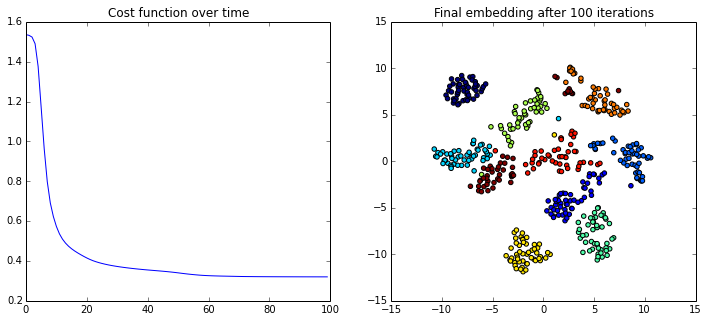

Reducing intermediate dimension from  64  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


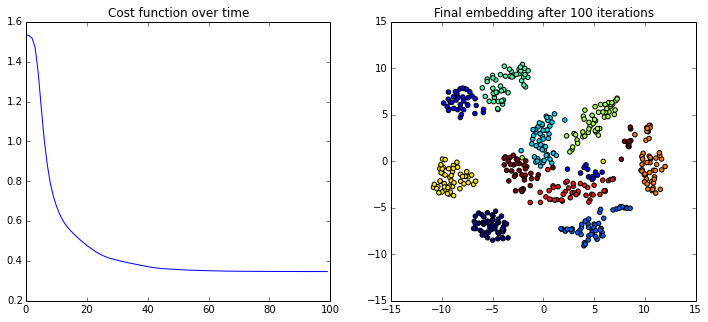

In [6]:
d,c=utils.get_data(type=2)
TSNE(d, max_iter = 100, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=13, visualize = False)
TSNE(d, max_iter = 100, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=7, visualize = False)

What kind of insight into the dataset you're dealing with can tSNE provide? Show one such example:

Answer: One can get a high-level overview of number of clusters but it's also possible to get an understanding of local structure within a cluster.

Generating clusters
number of clusters
Reducing intermediate dimension from  70  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


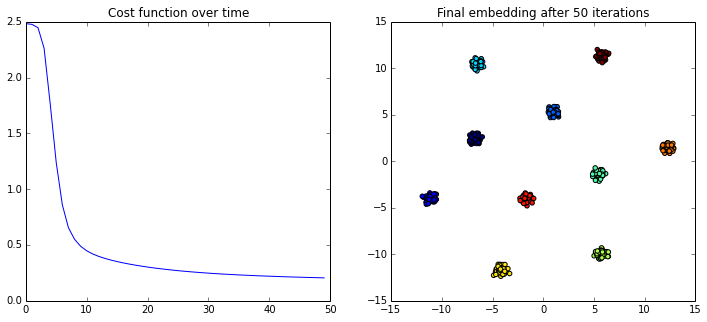

local structure within cluster
Reducing intermediate dimension from  70  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


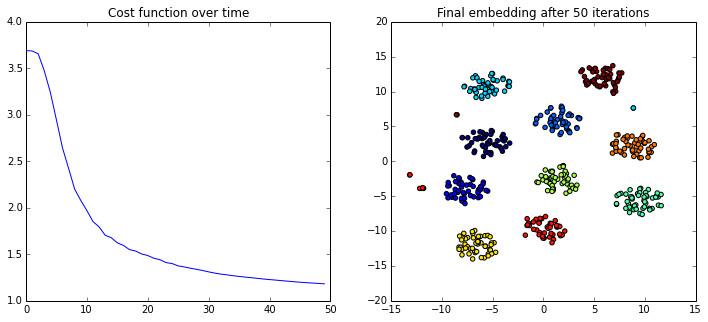

In [7]:
d,c=utils.get_data(type=5)
print('number of clusters')
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=13, early_exaggeration=0, seed=1, visualize = False)
print('local structure within cluster')
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=5, early_exaggeration=0, seed=1, visualize = False)

How does the learning rate (eta $\eta$) impact performance? 

Answer: A high learning rate solves the gradient descent faster, but more easily misses local optima, i.e. it takes fewer iterations to come up with a possibly less optimal solution.
It's usually best to use an adaptive learning rate or at least to reduce it after a few iterations.

Generating swiss roll
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


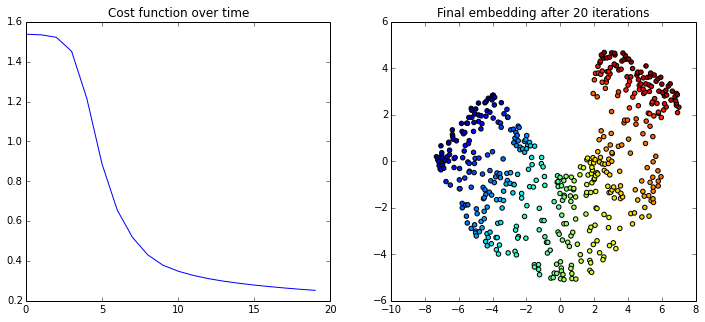

 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


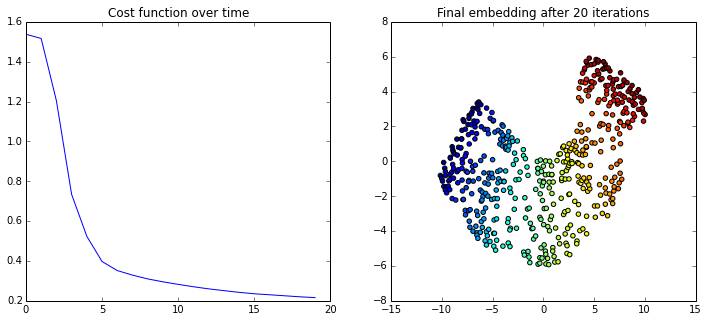

In [8]:
d,c=utils.get_data(type=1)
TSNE(d, max_iter = 20, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=7, visualize = False)
TSNE(d, eta=1000, max_iter = 20, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=7, visualize = False)

Find a combination of parameters for each dataset which provides an embedding you find good or explain why no such embedding exists for the particular dataset.

Generating swiss roll
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


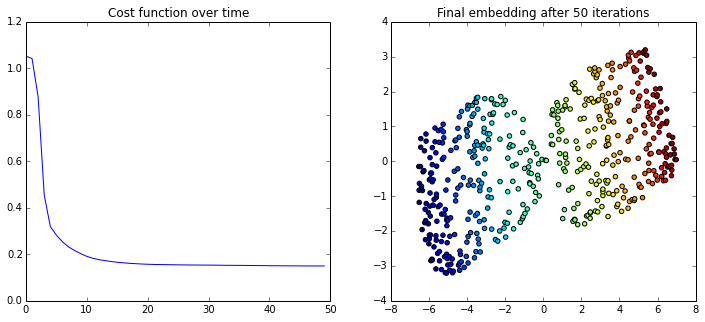

Loading digits
Reducing intermediate dimension from  64  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


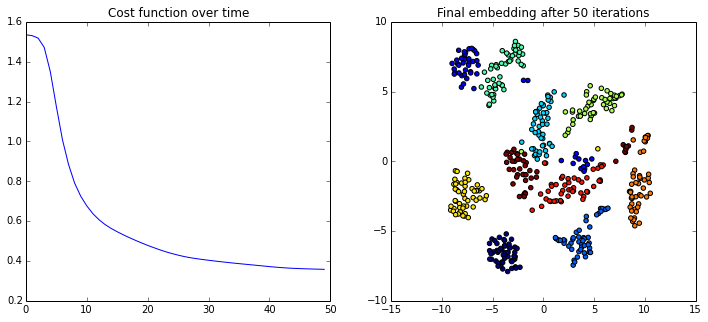

In [9]:
d,c=utils.get_data(type=1)
TSNE(d, eta=1000, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=35,  early_exaggeration=0, seed=7, visualize = False)
d,c=utils.get_data(type=2)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=7, visualize = False)


bad embedding b/c of highly non-metric data
Loading boston housing
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  2  seconds
Started work on t-SNE


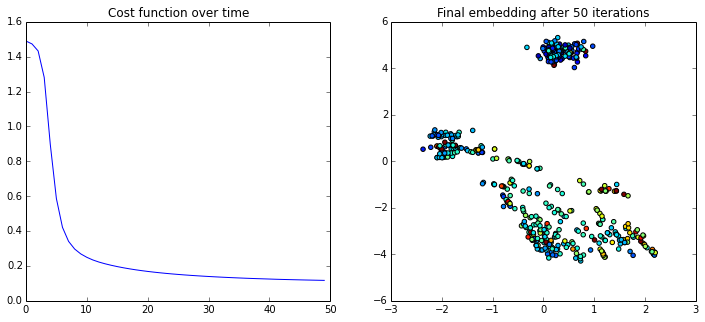

In [10]:
print('bad embedding b/c of highly non-metric data')
d,c=utils.get_data(type=3)
TSNE(d, max_iter = 50, labels = c, target_dimension = 14, intermediate_dimension = 50, perplexity=25,  early_exaggeration=0, seed=7, visualize = False)


Loading iris
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


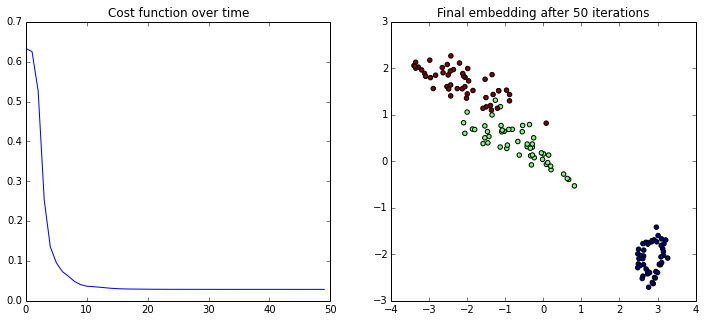

Generating clusters
Reducing intermediate dimension from  70  to  50  using PCA 
 Started optimizing sigmas 
Progress:  0 % duration  1  seconds
Progress:  20 % duration  1  seconds
Progress:  40 % duration  1  seconds
Progress:  60 % duration  1  seconds
Progress:  80 % duration  1  seconds
Progress: 100% duration  1  seconds
Started work on t-SNE


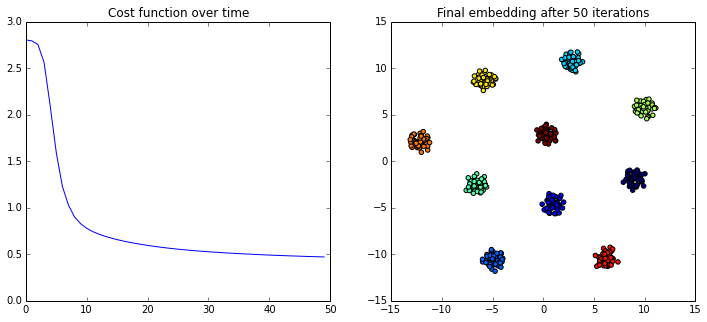

In [11]:
d,c=utils.get_data(type=4)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=20,  early_exaggeration=0, seed=7, visualize = False)
d,c=utils.get_data(type=5)
TSNE(d, max_iter = 50, labels = c, target_dimension = 2, intermediate_dimension = 50, perplexity=10,  early_exaggeration=0, seed=7, visualize = False)

What function does the gains array play in the code? What happens to values that are frequently increased? What happens to those who oscilate around a single value? 

Answer: The gains array controls the 2nd order momentum for the update steps and adaptively reduces the update step when crossing zero.